In [1]:
import os,glob,shutil,random
import tensorflow as tf
from keras.layers import Dense,MaxPool2D,Conv2D,Flatten,Dropout,Activation,BatchNormalization,Input
from matplotlib import pyplot as plt
import numpy as np
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam,RMSprop
from keras.activations import relu
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.applications.vgg19 import VGG19
from keras.regularizers import l2
from tensorflow.keras.layers.experimental import preprocessing
import wandb
from wandb.keras import WandbCallback
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
import pandas as pd

In [2]:
devices = tf.config.experimental.list_physical_devices()
print(devices)
tf.config.experimental.set_memory_growth(devices[1],True)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
DATASET_DIR = "Garbage Classification 3\Images_of_Waste\\rawimgs"

In [4]:
waste_names = os.listdir(DATASET_DIR)

In [5]:
len(waste_names)

4

In [6]:
os.getcwd()

'd:\\Pyhton Projects\\Projects\\Garbage Classification'

In [7]:

waste_counts = {}    

for waste in waste_names:

    waste_counts[waste]=len(os.listdir(DATASET_DIR+"/"+waste))



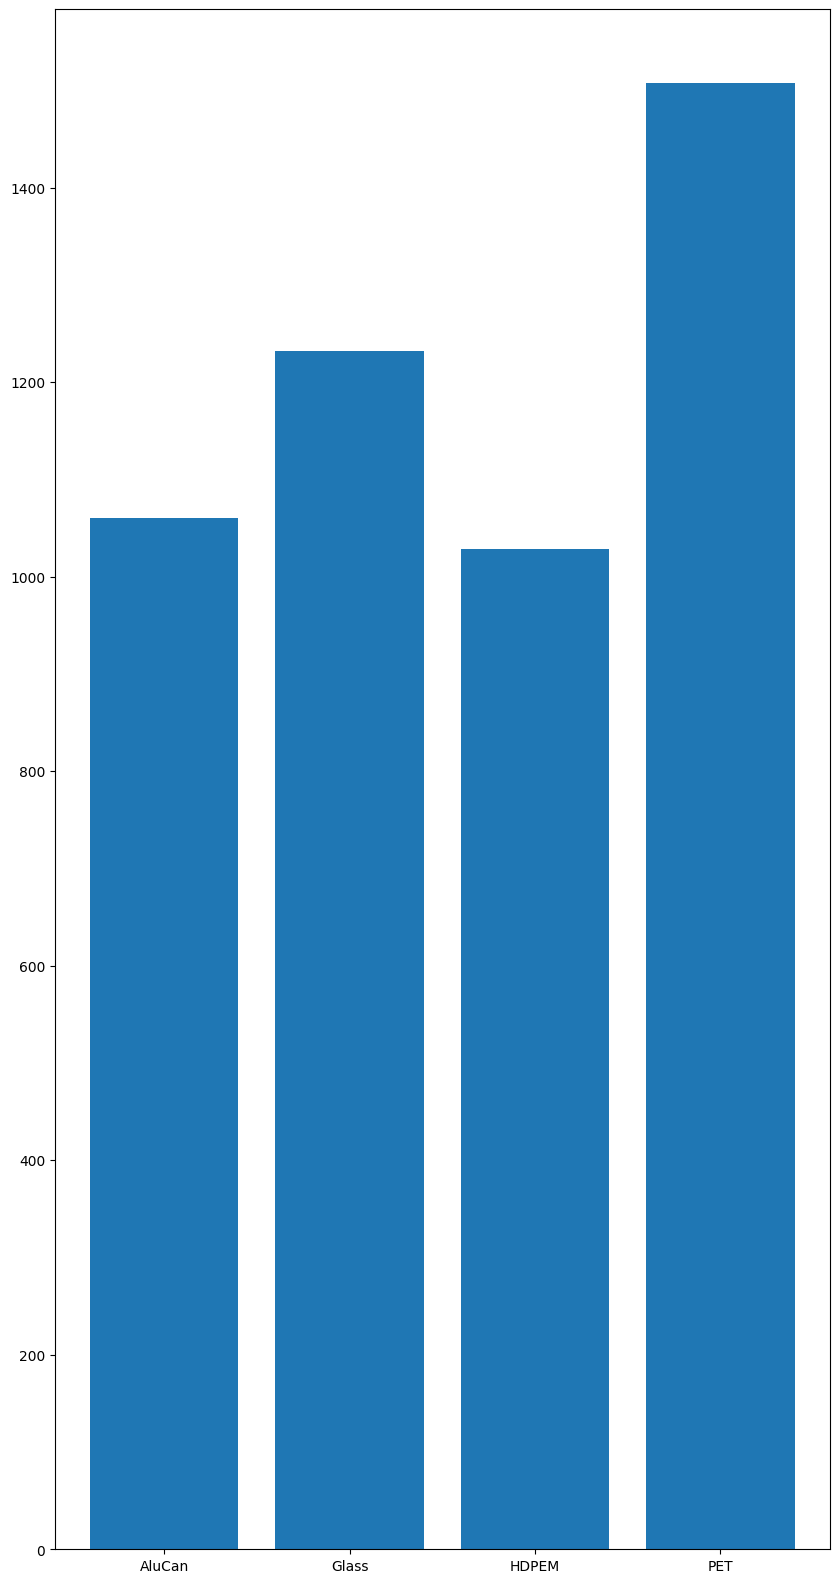

In [8]:

from matplotlib import pyplot as plt


plt.figure(figsize=(10,20))
mushroom_counts2 = [waste_counts.values()]

names = list(waste_counts.keys())
values = list(waste_counts.values())

plt.bar(range(len(waste_counts)), values, tick_label=names)

plt.show()



DATA AUGMENTATION

In [9]:
def augmentation():   
    data_gen = tf.keras.preprocessing.image.ImageDataGenerator(
        rotation_range=40, 
        width_shift_range=0.2,
        height_shift_range=0.2, 
        shear_range=0.2,
        zoom_range=0.2,
        fill_mode='nearest',
        horizontal_flip=True,
        
        )

    mn = sum(list(waste_counts.values())) // len(list(waste_counts.values()))



    for waste in waste_names:
        
        count = (mn)//(waste_counts[waste])

        img_counter = 0

        if count>0:

            for filename in os.listdir(f'{DATASET_DIR}//{waste}//'):
            
                img = load_img(f'{DATASET_DIR}//{waste}//{filename}')
                
                x = img_to_array(img)

                x = x.reshape((1,) + x.shape)

                for i in range(count):

                    data_gen.flow(x,batch_size=1, save_to_dir=(f'{DATASET_DIR}//{waste}'), save_prefix='IMG', save_format='.jpeg').next()
                        
                    img_counter +=1

            print(f"{waste} tamamlandı. {str(count+1)} kez {img_counter} resim üretildi...")

#augmentation()


In [10]:
waste_counts = {}    

for waste in waste_names:

    waste_counts[waste]=len(os.listdir(DATASET_DIR+"/"+waste))



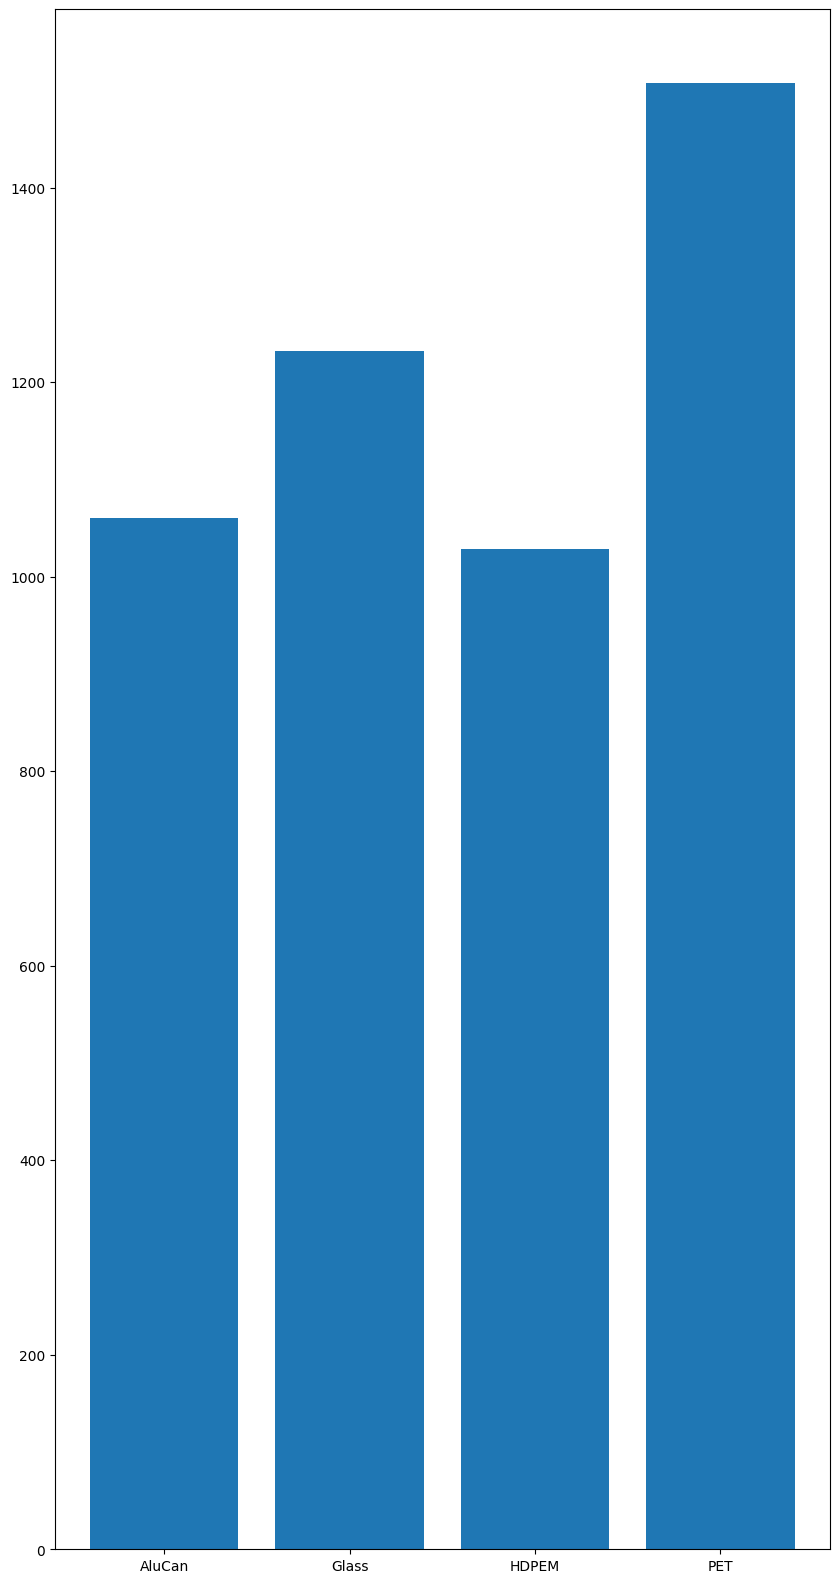

In [11]:
from matplotlib import pyplot as plt


plt.figure(figsize=(10,20))
mushroom_counts2 = [waste_counts.values()]

names = list(waste_counts.keys())
values = list(waste_counts.values())

plt.bar(range(len(waste_counts)), values, tick_label=names)

plt.show()



Tensorflow Part

In [12]:
from keras.preprocessing.image import image_dataset_from_directory

train_batchs = image_dataset_from_directory(

    						label_mode="int",
                           	subset="training",
                            validation_split=0.2,
        					seed=123,
                            directory=DATASET_DIR,
                            image_size=(224,224),
                            batch_size=10,
                            shuffle=True,
                           
                            )


valid_batchs = image_dataset_from_directory(	

    						label_mode="int",
                           	subset="validation",
        					seed=123,
                            validation_split=0.2,
                            directory=DATASET_DIR,
                            image_size=(224,224),
                            batch_size=10,
                            shuffle=True
                            
                            )

Found 4820 files belonging to 4 classes.
Using 3856 files for training.
Found 4820 files belonging to 4 classes.
Using 964 files for validation.


In [13]:
classes=list(train_batchs.class_names)
class_indices=list(train_batchs.class_names)
num_of_classes=len(classes)
num_of_classes

4

In [14]:
print(list(train_batchs.class_names))

['AluCan', 'Glass', 'HDPEM', 'PET']


In [15]:
CLASS_NUM = len(train_batchs.class_names)
CLASS_NUM

4

In [16]:
values = list(train_batchs.take(1))[0]
values

(<tf.Tensor: shape=(10, 224, 224, 3), dtype=float32, numpy=
 array([[[[157.84805  , 139.84805  , 117.18288  ],
          [137.83385  , 119.90529  , 105.619576 ],
          [121.231346 , 105.231346 ,  92.231346 ],
          ...,
          [158.42882  , 141.42882  , 123.0003   ],
          [141.33266  , 124.33265  , 106.33265  ],
          [152.93245  , 136.93245  , 120.93244  ]],
 
         [[169.25494  , 151.2076   , 131.34966  ],
          [146.99011  , 129.06154  , 114.918686 ],
          [114.57366  ,  98.57366  ,  85.54209  ],
          ...,
          [141.01491  , 124.01491  , 105.58638  ],
          [133.97151  , 118.97151  ,  99.97151  ],
          [154.95526  , 138.95526  , 122.95527  ]],
 
         [[161.41757  , 142.41757  , 126.79098  ],
          [159.35332  , 141.53876  , 127.16789  ],
          [119.480865 , 103.45456  ,  88.24027  ],
          ...,
          [140.58025  , 125.15172  , 105.937454 ],
          [157.91978  , 142.79703  , 124.16532  ],
          [145.62727  

In [17]:
imgs,labels = values[0],values[1]
imgs,labels

(<tf.Tensor: shape=(10, 224, 224, 3), dtype=float32, numpy=
 array([[[[157.84805  , 139.84805  , 117.18288  ],
          [137.83385  , 119.90529  , 105.619576 ],
          [121.231346 , 105.231346 ,  92.231346 ],
          ...,
          [158.42882  , 141.42882  , 123.0003   ],
          [141.33266  , 124.33265  , 106.33265  ],
          [152.93245  , 136.93245  , 120.93244  ]],
 
         [[169.25494  , 151.2076   , 131.34966  ],
          [146.99011  , 129.06154  , 114.918686 ],
          [114.57366  ,  98.57366  ,  85.54209  ],
          ...,
          [141.01491  , 124.01491  , 105.58638  ],
          [133.97151  , 118.97151  ,  99.97151  ],
          [154.95526  , 138.95526  , 122.95527  ]],
 
         [[161.41757  , 142.41757  , 126.79098  ],
          [159.35332  , 141.53876  , 127.16789  ],
          [119.480865 , 103.45456  ,  88.24027  ],
          ...,
          [140.58025  , 125.15172  , 105.937454 ],
          [157.91978  , 142.79703  , 124.16532  ],
          [145.62727  

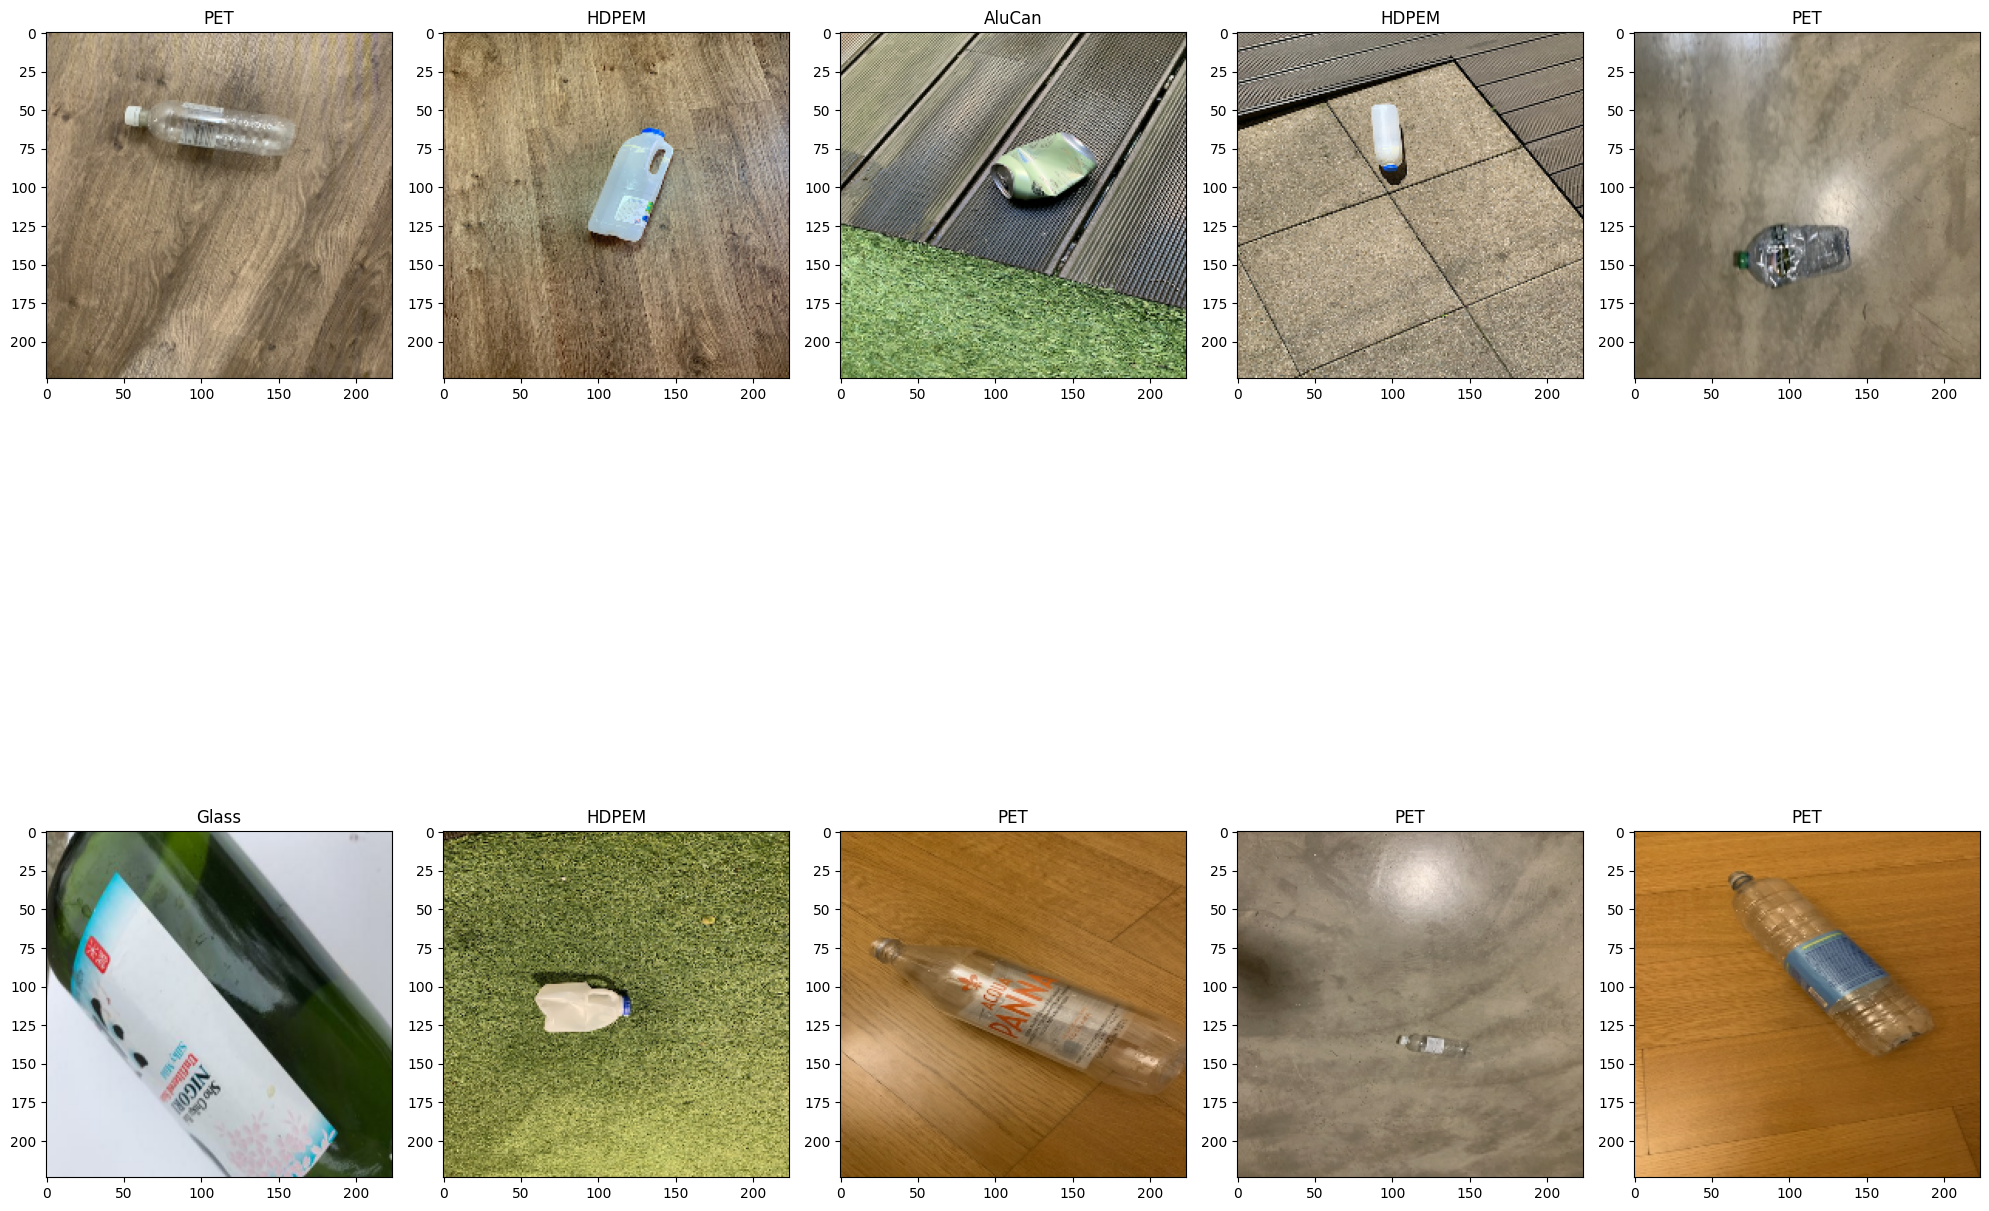

In [18]:
def plotImages(images,labels):
    
    fig,axes = plt.subplots(2,5,figsize=(20,20))
    
    axes = axes.flatten()
    
    for image,label,axe in zip(images,labels,axes):
        
        axe.imshow(image/255)
        axe.set_title(list(train_batchs.class_names)[int(label)])

    plt.tight_layout()
    plt.show()
    
    
plotImages(imgs,labels)

CREATE MODEL

In [19]:
resize_and_rescale = Sequential([

preprocessing.Resizing(224,224),
preprocessing.Rescaling(1.0/255)

])

data_augmention = Sequential([

preprocessing.RandomFlip("horizontal"),
preprocessing.RandomRotation(0.2),
preprocessing.RandomZoom(0.2),
preprocessing.RandomContrast(0.4),




])




In [20]:

model = Sequential()

model.add(Input(shape=(224,224,3)))

model.add(resize_and_rescale)

model.add(data_augmention)

model.add(Conv2D(input_shape=(224,224,3),filters=32,kernel_size=(3,3),padding="same",activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=2))
model.add(BatchNormalization())

model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same",activation="relu"))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(BatchNormalization())


model.add(Conv2D(filters=128,kernel_size=(3,3),padding="same",activation="relu"))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(BatchNormalization())

model.add(Conv2D(filters=256,kernel_size=(2,2),padding="same",activation="relu"))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(BatchNormalization())

model.add(Conv2D(filters=128,kernel_size=(2,2),padding="same",activation="relu"))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(BatchNormalization())




model.add(Flatten())
model.add(Dense(256))
model.add(Activation(relu))
model.add(BatchNormalization())


model.add(Dense(units=CLASS_NUM,activation="softmax"))


In [21]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 224, 224, 3)       0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 224, 224, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 224, 224, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 32)      0         
_________________________________________________________________
batch_normalization (BatchNo (None, 112, 112, 32)      128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 64)       

In [22]:
model.compile(Adam(learning_rate=0.0005),SparseCategoricalCrossentropy(from_logits=False),metrics=["accuracy"])

In [23]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=5,  restore_best_weights=True)
filepath = "model/saved-model-{epoch:02d}-{val_accuracy:.2f}.hdf5"
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_accuracy', save_best_only=True, mode='max')
model.fit(x=train_batchs,validation_data=(valid_batchs),workers=-1,epochs=100,verbose=1, callbacks=[es,checkpoint])

Epoch 1/100
386/386 [==============================] - 102s 254ms/step - loss: 1.1185 - accuracy: 0.5869 - val_loss: 1.5650 - val_accuracy: 0.4481
Epoch 2/100
386/386 [==============================] - 21s 54ms/step - loss: 0.7976 - accuracy: 0.6942 - val_loss: 0.6955 - val_accuracy: 0.7562
Epoch 3/100
386/386 [==============================] - 21s 55ms/step - loss: 0.6362 - accuracy: 0.7593 - val_loss: 1.0103 - val_accuracy: 0.7002
Epoch 4/100
386/386 [==============================] - 21s 55ms/step - loss: 0.5340 - accuracy: 0.8006 - val_loss: 3.5059 - val_accuracy: 0.4554
Epoch 5/100
386/386 [==============================] - 21s 55ms/step - loss: 0.4817 - accuracy: 0.8208 - val_loss: 3.7517 - val_accuracy: 0.4015
Epoch 6/100
386/386 [==============================] - 21s 55ms/step - loss: 0.4308 - accuracy: 0.8405 - val_loss: 3.5075 - val_accuracy: 0.3413
Epoch 7/100
386/386 [==============================] - 21s 55ms/step - loss: 0.3903 - accuracy: 0.8600 - val_loss: 0.4804 - val_

In [24]:
if os.path.isdir("model/model.h5") is False:
    model.save("model/model.h5")

In [25]:
output = model.evaluate(x=valid_batchs,verbose=1)
output 

97/97 [==============================] - 2s 15ms/step - loss: 0.3199 - accuracy: 0.8900


[0.31985822319984436, 0.8900414705276489]

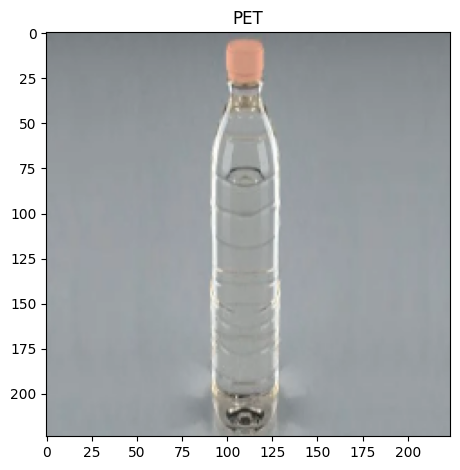

In [28]:
def predictImages(image):
    import cv2
   
    img = cv2.resize(cv2.imread(image),(224,224)) 
    
    plt.imshow(img)

    img = np.expand_dims(img, axis=0)

    plt.title(list(train_batchs.class_names)[np.argmax(np.squeeze(model.predict(np.array(img))))])

    plt.tight_layout()
    plt.show()
    
    
predictImages("test images\pet-sise-330-ml.JPG")

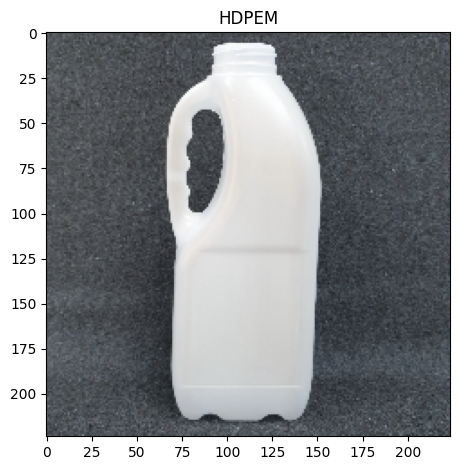

In [33]:
def predictImages(image):
    import cv2
   
    img = cv2.resize(cv2.imread(image),(224,224)) 
    
    plt.imshow(img)

    img = np.expand_dims(img, axis=0)

    plt.title(list(train_batchs.class_names)[np.argmax(np.squeeze(model.predict(np.array(img))))])

    plt.tight_layout()
    plt.show()
    
    
predictImages("test images\hdpem.jpg")